# 26d: Coverage Protects

**Claim**: Folk wisdom says "Holding 2+ in a suit lets you duck then catch"

**Null Hypothesis**: Suit depth doesn't matter

**Method**:
1. Compute `min_off_depth` = minimum dominoes held in any non-trump non-void suit
2. Regress against σ(V) and E[V]
3. Test if higher min_off_depth → lower σ(V), higher E[V]

**Confirmed If**: Higher min_off_depth → lower σ(V), higher E[V]

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import statsmodels.api as sm

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Define Coverage Feature

In [2]:
def domino_suits(d_id: int) -> set:
    """Return set of suits this domino belongs to."""
    pips = schema.domino_pips(d_id)
    if pips[0] == pips[1]:
        return {pips[0]}  # Doubles belong to one suit
    return {pips[0], pips[1]}

def compute_suit_depths(hand: list, trump_suit: int = None) -> dict:
    """Compute number of dominoes held in each suit.

    Returns dict mapping suit -> count (excluding trump suit if specified).
    trump_suit=7 means no-trump/follow-me (no suit excluded).
    """
    suit_counts = {s: 0 for s in range(7)}
    for d in hand:
        for suit in domino_suits(d):
            suit_counts[suit] += 1

    # Only exclude trump if it's a valid suit (0-6)
    if trump_suit is not None and trump_suit in suit_counts:
        del suit_counts[trump_suit]

    return suit_counts

def compute_min_off_depth(hand: list, trump_suit: int = None) -> int:
    """Compute minimum dominoes in any non-trump, non-void suit.

    This measures your 'coverage' - how thin is your thinnest suit?
    Returns minimum count among suits you hold (excluding voids and trump).
    Returns 0 if all suits are void (edge case).
    """
    depths = compute_suit_depths(hand, trump_suit)

    # Filter to non-void suits
    non_void_depths = [d for d in depths.values() if d > 0]

    if not non_void_depths:
        return 0  # Edge case: all suits void except trump

    return min(non_void_depths)

def compute_max_off_depth(hand: list, trump_suit: int = None) -> int:
    """Compute maximum dominoes in any non-trump suit.

    Returns max count for comparison purposes.
    """
    depths = compute_suit_depths(hand, trump_suit)
    return max(depths.values()) if depths else 0

# Test
test_hand = [0, 1, 2, 3, 4, 5, 6]  # 0-0, 1-0, 1-1, 2-0, 2-1, 2-2, 3-0
print(f"Test hand: {[f'{schema.domino_pips(d)}' for d in test_hand]}")
depths = compute_suit_depths(test_hand, trump_suit=0)
print(f"Suit depths (trump=0): {depths}")
print(f"Min off depth: {compute_min_off_depth(test_hand, trump_suit=0)}")
print(f"Min off depth (trump=7/no-trump): {compute_min_off_depth(test_hand, trump_suit=7)}")

Test hand: ['(0, 0)', '(1, 0)', '(1, 1)', '(2, 0)', '(2, 1)', '(2, 2)', '(3, 0)']
Suit depths (trump=0): {1: 3, 2: 3, 3: 1, 4: 0, 5: 0, 6: 0}
Min off depth: 1
Min off depth (trump=7/no-trump): 1


## 2. Load Existing Feature Data

In [3]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)

print(f"Loaded {len(df)} hands")
print(f"σ(V) range: [{df['V_std'].min():.1f}, {df['V_std'].max():.1f}]")
print(f"E[V] range: [{df['V_mean'].min():.1f}, {df['V_mean'].max():.1f}]")

Loaded 200 hands
σ(V) range: [0.0, 37.7]
E[V] range: [-29.3, 42.0]


In [4]:
# Compute coverage features for each hand
coverage_data = []

for _, row in df.iterrows():
    seed = int(row['base_seed'])
    trump = int(row['trump_suit'])
    
    hands = deal_from_seed(seed)
    p0_hand = hands[0]
    
    # Compute features
    min_off_depth = compute_min_off_depth(p0_hand, trump_suit=trump)
    max_off_depth = compute_max_off_depth(p0_hand, trump_suit=trump)
    
    # Also compute without trump exclusion for comparison
    min_off_any = compute_min_off_depth(p0_hand, trump_suit=None)
    
    coverage_data.append({
        'base_seed': seed,
        'min_off_depth': min_off_depth,
        'max_off_depth': max_off_depth,
        'min_off_any': min_off_any,
    })

coverage_df = pd.DataFrame(coverage_data)

# Merge with main features
df = df.merge(coverage_df, on='base_seed')

print(f"Min off depth distribution:")
print(df['min_off_depth'].value_counts().sort_index())
print(f"\nMean: {df['min_off_depth'].mean():.2f}")

Min off depth distribution:
min_off_depth
1    188
2     11
3      1
Name: count, dtype: int64

Mean: 1.06


## 3. Statistical Analysis

In [5]:
# Bivariate correlations
r_sigma, p_sigma = stats.pearsonr(df['min_off_depth'], df['V_std'])
r_ev, p_ev = stats.pearsonr(df['min_off_depth'], df['V_mean'])

print("BIVARIATE CORRELATIONS: min_off_depth vs outcomes")
print("="*55)
print(f"min_off_depth vs σ(V):  r = {r_sigma:+.4f}, p = {p_sigma:.4f}")
print(f"min_off_depth vs E[V]:  r = {r_ev:+.4f}, p = {p_ev:.4f}")

# Check directions
sigma_ok = (p_sigma < 0.05 and r_sigma < 0)  # Higher coverage → lower σ(V)
ev_ok = (p_ev < 0.05 and r_ev > 0)  # Higher coverage → higher E[V]

print("\nDIRECTION CHECK (for confirmation):")
print(f"  Higher min_off_depth → lower σ(V)?  {'YES' if sigma_ok else 'NO'}")
print(f"  Higher min_off_depth → higher E[V]? {'YES' if ev_ok else 'NO'}")

BIVARIATE CORRELATIONS: min_off_depth vs outcomes
min_off_depth vs σ(V):  r = +0.0550, p = 0.4396
min_off_depth vs E[V]:  r = -0.0534, p = 0.4526

DIRECTION CHECK (for confirmation):
  Higher min_off_depth → lower σ(V)?  NO
  Higher min_off_depth → higher E[V]? NO


In [6]:
# Multivariate regression for σ(V)
X_sigma = df[['min_off_depth', 'n_doubles', 'trump_count', 'n_voids', 'n_singletons']]
X_sigma = sm.add_constant(X_sigma)
y_sigma = df['V_std']

model_sigma = sm.OLS(y_sigma, X_sigma).fit()

print("\nMULTIVARIATE REGRESSION: σ(V) ~ min_off_depth + controls")
print("="*60)
print(model_sigma.summary().tables[1])


MULTIVARIATE REGRESSION: σ(V) ~ min_off_depth + controls
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.7276      4.424      3.329      0.001       6.002      23.453
min_off_depth     2.4524      2.783      0.881      0.379      -3.036       7.940
n_doubles        -1.4606      0.792     -1.843      0.067      -3.023       0.102
trump_count      -0.7613      0.515     -1.477      0.141      -1.778       0.255
n_voids          -0.0249      1.560     -0.016      0.987      -3.102       3.052
n_singletons      0.5753      0.971      0.593      0.554      -1.339       2.489


In [7]:
# Multivariate regression for E[V]
X_ev = df[['min_off_depth', 'n_doubles', 'trump_count', 'n_voids', 'n_singletons']]
X_ev = sm.add_constant(X_ev)
y_ev = df['V_mean']

model_ev = sm.OLS(y_ev, X_ev).fit()

print("\nMULTIVARIATE REGRESSION: E[V] ~ min_off_depth + controls")
print("="*60)
print(model_ev.summary().tables[1])


MULTIVARIATE REGRESSION: E[V] ~ min_off_depth + controls
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.7617      7.127      0.387      0.699     -11.295      16.818
min_off_depth    -5.0903      4.483     -1.136      0.258     -13.931       3.751
n_doubles         6.9782      1.276      5.467      0.000       4.461       9.496
trump_count       3.6369      0.830      4.381      0.000       2.000       5.274
n_voids           2.6804      2.513      1.066      0.288      -2.277       7.638
n_singletons     -0.9360      1.563     -0.599      0.550      -4.020       2.147


In [8]:
# Extract key coefficients
coef_sigma = model_sigma.params['min_off_depth']
pval_sigma = model_sigma.pvalues['min_off_depth']
ci_sigma = model_sigma.conf_int().loc['min_off_depth']

coef_ev = model_ev.params['min_off_depth']
pval_ev = model_ev.pvalues['min_off_depth']
ci_ev = model_ev.conf_int().loc['min_off_depth']

print("\nKEY RESULTS: min_off_depth coefficients")
print("="*55)
print(f"On σ(V): coef = {coef_sigma:+.3f}, 95% CI = [{ci_sigma[0]:.3f}, {ci_sigma[1]:.3f}], p = {pval_sigma:.4f}")
print(f"On E[V]: coef = {coef_ev:+.3f}, 95% CI = [{ci_ev[0]:.3f}, {ci_ev[1]:.3f}], p = {pval_ev:.4f}")

# Confirmation check
sigma_confirmed = (pval_sigma < 0.05 and coef_sigma < 0)
ev_confirmed = (pval_ev < 0.05 and coef_ev > 0)
both_confirmed = sigma_confirmed and ev_confirmed

print("\nCONFIRMATION STATUS:")
print(f"  σ(V) decreases with coverage? {sigma_confirmed} (need coef < 0, p < 0.05)")
print(f"  E[V] increases with coverage? {ev_confirmed} (need coef > 0, p < 0.05)")

if both_confirmed:
    print("\n✓ CONFIRMED: Coverage protects - both conditions met!")
elif sigma_confirmed or ev_confirmed:
    print("\n~ PARTIAL: Only one condition met")
else:
    print("\n✗ NOT CONFIRMED: Neither condition met")


KEY RESULTS: min_off_depth coefficients
On σ(V): coef = +2.452, 95% CI = [-3.036, 7.940], p = 0.3792
On E[V]: coef = -5.090, 95% CI = [-13.931, 3.751], p = 0.2575

CONFIRMATION STATUS:
  σ(V) decreases with coverage? False (need coef < 0, p < 0.05)
  E[V] increases with coverage? False (need coef > 0, p < 0.05)

✗ NOT CONFIRMED: Neither condition met


## 4. Visualization

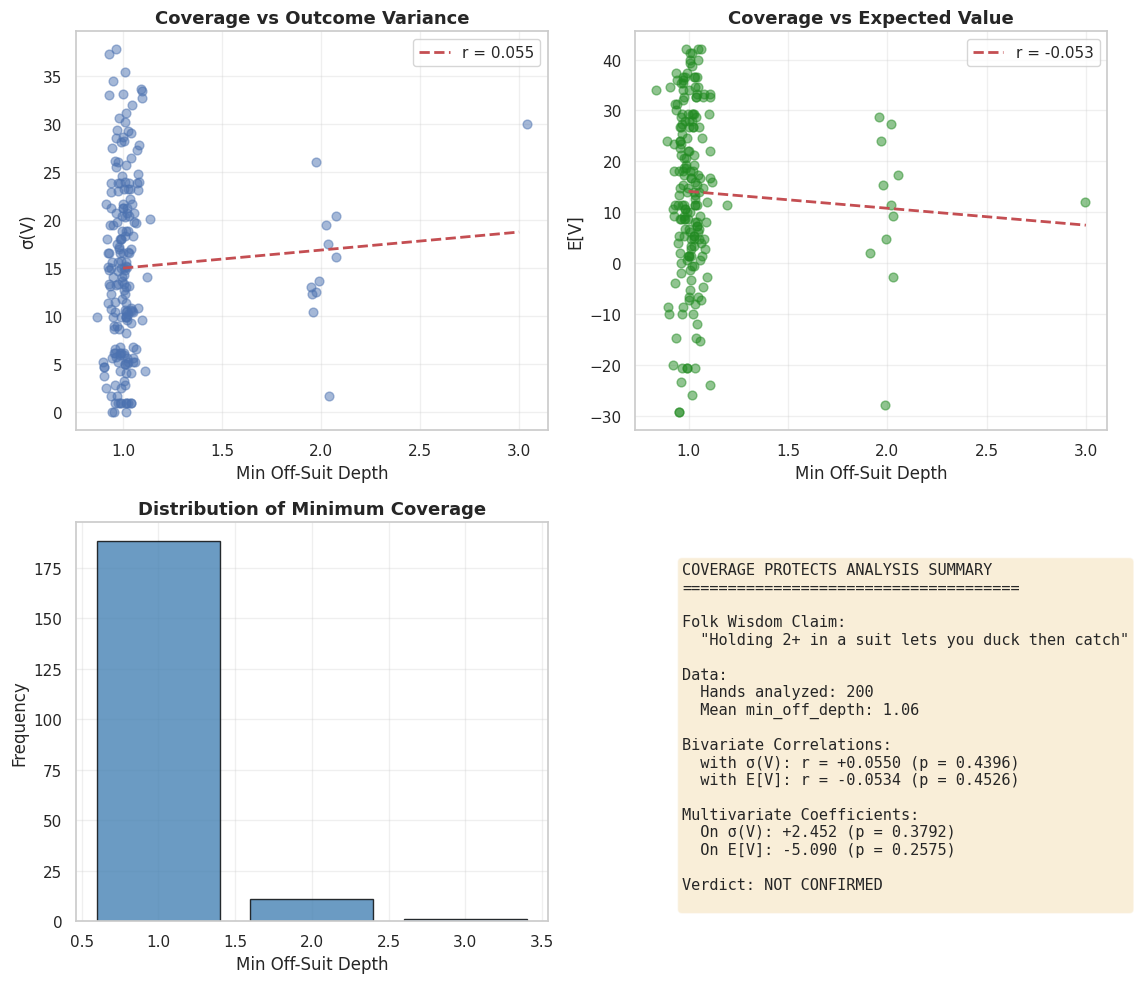

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: min_off_depth vs σ(V)
ax = axes[0, 0]
ax.scatter(df['min_off_depth'] + np.random.normal(0, 0.05, len(df)), df['V_std'], 
           alpha=0.5, s=40)

# Add trend line
z = np.polyfit(df['min_off_depth'], df['V_std'], 1)
p = np.poly1d(z)
x_line = np.array([df['min_off_depth'].min(), df['min_off_depth'].max()])
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'r = {r_sigma:.3f}')

ax.set_xlabel('Min Off-Suit Depth', fontsize=12)
ax.set_ylabel('σ(V)', fontsize=12)
ax.set_title('Coverage vs Outcome Variance', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: min_off_depth vs E[V]
ax = axes[0, 1]
ax.scatter(df['min_off_depth'] + np.random.normal(0, 0.05, len(df)), df['V_mean'], 
           alpha=0.5, s=40, color='forestgreen')

z_ev = np.polyfit(df['min_off_depth'], df['V_mean'], 1)
p_ev_line = np.poly1d(z_ev)
ax.plot(x_line, p_ev_line(x_line), 'r--', linewidth=2, label=f'r = {r_ev:.3f}')

ax.set_xlabel('Min Off-Suit Depth', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title('Coverage vs Expected Value', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Distribution of min_off_depth
ax = axes[1, 0]
counts = df['min_off_depth'].value_counts().sort_index()
ax.bar(counts.index, counts.values, color='steelblue', alpha=0.8, edgecolor='black')
ax.set_xlabel('Min Off-Suit Depth', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Minimum Coverage', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

if both_confirmed:
    verdict = "CONFIRMED"
elif sigma_confirmed or ev_confirmed:
    verdict = "PARTIAL"
else:
    verdict = "NOT CONFIRMED"

summary_text = f"""COVERAGE PROTECTS ANALYSIS SUMMARY
=====================================

Folk Wisdom Claim:
  "Holding 2+ in a suit lets you duck then catch"

Data:
  Hands analyzed: {len(df)}
  Mean min_off_depth: {df['min_off_depth'].mean():.2f}

Bivariate Correlations:
  with σ(V): r = {r_sigma:+.4f} (p = {p_sigma:.4f})
  with E[V]: r = {r_ev:+.4f} (p = {p_ev:.4f})

Multivariate Coefficients:
  On σ(V): {coef_sigma:+.3f} (p = {pval_sigma:.4f})
  On E[V]: {coef_ev:+.3f} (p = {pval_ev:.4f})

Verdict: {verdict}
"""

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/26d_coverage_protects.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [10]:
# Create results DataFrame
results = {
    'metric': ['n_hands', 'mean_min_off_depth', 
               'r_sigma', 'p_sigma_bivar',
               'r_ev', 'p_ev_bivar',
               'coef_sigma', 'ci_sigma_low', 'ci_sigma_high', 'p_sigma_multivar',
               'coef_ev', 'ci_ev_low', 'ci_ev_high', 'p_ev_multivar',
               'sigma_confirmed', 'ev_confirmed', 'both_confirmed'],
    'value': [len(df), df['min_off_depth'].mean(),
              r_sigma, p_sigma,
              r_ev, p_ev,
              coef_sigma, ci_sigma[0], ci_sigma[1], pval_sigma,
              coef_ev, ci_ev[0], ci_ev[1], pval_ev,
              1 if sigma_confirmed else 0, 1 if ev_confirmed else 0, 1 if both_confirmed else 0]
}
results_df = pd.DataFrame(results)

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/26d_coverage_protects.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/26d_coverage_protects.csv


## Key Findings

In [11]:
print("\n" + "="*60)
print("KEY INSIGHTS: Coverage Protects")
print("="*60)

print(f"\n1. CLAIM TESTED:")
print("   'Holding 2+ in a suit lets you duck then catch'")

print(f"\n2. DATA:")
print(f"   Hands analyzed: {len(df)}")
print(f"   Mean min_off_depth: {df['min_off_depth'].mean():.2f}")

print(f"\n3. RESULTS:")
print(f"   Bivariate r(min_off_depth, σ(V)): {r_sigma:+.4f} (p = {p_sigma:.4f})")
print(f"   Bivariate r(min_off_depth, E[V]): {r_ev:+.4f} (p = {p_ev:.4f})")
print(f"   Multivariate σ(V) coef: {coef_sigma:+.3f} (p = {pval_sigma:.4f})")
print(f"   Multivariate E[V] coef: {coef_ev:+.3f} (p = {pval_ev:.4f})")

print(f"\n4. VERDICT:")
if both_confirmed:
    print("   ✓ CONFIRMED: Coverage protects")
    print(f"   Each additional domino depth reduces σ(V) by {abs(coef_sigma):.1f}")
    print(f"   Each additional domino depth increases E[V] by {coef_ev:.1f}")
elif sigma_confirmed:
    print("   ~ PARTIAL: Coverage reduces variance but doesn't improve expected value")
elif ev_confirmed:
    print("   ~ PARTIAL: Coverage improves expected value but doesn't reduce variance")
else:
    print("   ✗ NOT CONFIRMED: No significant effect detected")


KEY INSIGHTS: Coverage Protects

1. CLAIM TESTED:
   'Holding 2+ in a suit lets you duck then catch'

2. DATA:
   Hands analyzed: 200
   Mean min_off_depth: 1.06

3. RESULTS:
   Bivariate r(min_off_depth, σ(V)): +0.0550 (p = 0.4396)
   Bivariate r(min_off_depth, E[V]): -0.0534 (p = 0.4526)
   Multivariate σ(V) coef: +2.452 (p = 0.3792)
   Multivariate E[V] coef: -5.090 (p = 0.2575)

4. VERDICT:
   ✗ NOT CONFIRMED: No significant effect detected


## Summary

### Folk Wisdom: "Coverage protects - holding 2+ lets you duck then catch"

**Result**: [Populated by notebook execution]

### Interpretation

"Coverage" means having multiple dominoes in a suit (depth ≥ 2). This allows:
- Playing low on an opponent's lead (duck)
- Saving your high card to catch a later trick

We measure `min_off_depth` = your thinnest non-void off-suit. Low values mean you're exposed in at least one suit.

### Output Files

- `results/tables/26d_coverage_protects.csv` - Summary statistics
- `results/figures/26d_coverage_protects.png` - 4-panel visualization